In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
zip_path = '/content/drive/MyDrive/KOSA/fruit.zip'

In [3]:
import zipfile

In [4]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/fruit')  # Colab 환경에 압축 해제될 경로

In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [6]:
import torch

In [7]:
class FruitDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.images = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))

        for label_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.images.append(img_path)
                self.labels.append(label_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [9]:
train_dataset = FruitDataset('/content/fruit/Fruits Classification/train', transform=transform)
valid_dataset = FruitDataset('/content/fruit/Fruits Classification/valid', transform=transform)


In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [11]:
for images, labels in train_loader:
    print(f"이미지 배치 크기: {images.size()}")
    print(f"레이블 배치 크기: {labels.size()}")
    break

이미지 배치 크기: torch.Size([32, 3, 224, 224])
레이블 배치 크기: torch.Size([32])


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [14]:
mobilenet_v3 = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
num_classes = len(train_dataset.classes)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 85.3MB/s]


In [15]:
mobilenet_v3.classifier[3] = nn.Linear(mobilenet_v3.classifier[3].in_features, num_classes)

Frozen Backbone

In [16]:
model_frozen = mobilenet_v3
for param in model_frozen.features.parameters():
    param.requires_grad = False

In [17]:
model_frozen = model_frozen.to(device)

Unfrozen Backbone

In [19]:
mobilenet_v3_unfrozen = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
mobilenet_v3_unfrozen.classifier[3] = nn.Linear(mobilenet_v3_unfrozen.classifier[3].in_features, num_classes)

In [20]:
model_unfrozen = mobilenet_v3_unfrozen.to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer_frozen = optim.Adam(filter(lambda p: p.requires_grad, model_frozen.parameters()), lr=0.001)
optimizer_unfrozen = optim.Adam(model_unfrozen.parameters(), lr=0.001)

비교 시작

In [26]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = total_correct / len(loader.dataset)
    return avg_loss, avg_acc

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = total_correct / len(loader.dataset)
    return avg_loss, avg_acc


In [27]:
import matplotlib.pyplot as plt

num_epochs = 5  # 원하시면 늘리세요

history = {
    "frozen_train_loss": [],
    "frozen_valid_loss": [],
    "frozen_train_acc": [],
    "frozen_valid_acc": [],
    "unfrozen_train_loss": [],
    "unfrozen_valid_loss": [],
    "unfrozen_train_acc": [],
    "unfrozen_valid_acc": [],
}

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Frozen 학습 & 검증
    f_train_loss, f_train_acc = train_one_epoch(model_frozen, train_loader, optimizer_frozen, criterion, device)
    f_valid_loss, f_valid_acc = validate_one_epoch(model_frozen, valid_loader, criterion, device)

    # Unfrozen 학습 & 검증
    u_train_loss, u_train_acc = train_one_epoch(model_unfrozen, train_loader, optimizer_unfrozen, criterion, device)
    u_valid_loss, u_valid_acc = validate_one_epoch(model_unfrozen, valid_loader, criterion, device)

    # 기록
    history["frozen_train_loss"].append(f_train_loss)
    history["frozen_valid_loss"].append(f_valid_loss)
    history["frozen_train_acc"].append(f_train_acc)
    history["frozen_valid_acc"].append(f_valid_acc)

    history["unfrozen_train_loss"].append(u_train_loss)
    history["unfrozen_valid_loss"].append(u_valid_loss)
    history["unfrozen_train_acc"].append(u_train_acc)
    history["unfrozen_valid_acc"].append(u_valid_acc)

    print(f"[Frozen] Train Loss: {f_train_loss:.4f} | Valid Loss: {f_valid_loss:.4f} | Train Acc: {f_train_acc:.4f} | Valid Acc: {f_valid_acc:.4f}")
    print(f"[Unfrozen] Train Loss: {u_train_loss:.4f} | Valid Loss: {u_valid_loss:.4f} | Train Acc: {u_train_acc:.4f} | Valid Acc: {u_valid_acc:.4f}")


Epoch 1/5
[Frozen] Train Loss: 0.3097 | Valid Loss: 0.3255 | Train Acc: 0.8897 | Valid Acc: 0.8950
[Unfrozen] Train Loss: 0.2500 | Valid Loss: 0.4218 | Train Acc: 0.9149 | Valid Acc: 0.8650
Epoch 2/5
[Frozen] Train Loss: 0.2209 | Valid Loss: 0.2998 | Train Acc: 0.9223 | Valid Acc: 0.9100
[Unfrozen] Train Loss: 0.2005 | Valid Loss: 0.4093 | Train Acc: 0.9309 | Valid Acc: 0.8550
Epoch 3/5
[Frozen] Train Loss: 0.1776 | Valid Loss: 0.3151 | Train Acc: 0.9354 | Valid Acc: 0.8950
[Unfrozen] Train Loss: 0.1747 | Valid Loss: 0.2988 | Train Acc: 0.9414 | Valid Acc: 0.9100
Epoch 4/5
[Frozen] Train Loss: 0.1341 | Valid Loss: 0.2851 | Train Acc: 0.9526 | Valid Acc: 0.9100
[Unfrozen] Train Loss: 0.1194 | Valid Loss: 0.3703 | Train Acc: 0.9614 | Valid Acc: 0.9050
Epoch 5/5
[Frozen] Train Loss: 0.1005 | Valid Loss: 0.2284 | Train Acc: 0.9634 | Valid Acc: 0.9200
[Unfrozen] Train Loss: 0.1117 | Valid Loss: 0.2545 | Train Acc: 0.9627 | Valid Acc: 0.9200


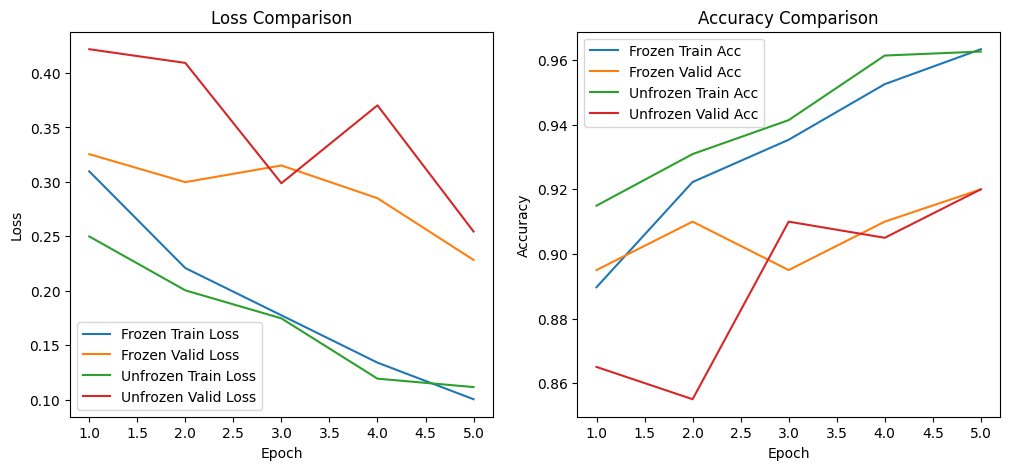

In [28]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["frozen_train_loss"], label="Frozen Train Loss")
plt.plot(epochs, history["frozen_valid_loss"], label="Frozen Valid Loss")
plt.plot(epochs, history["unfrozen_train_loss"], label="Unfrozen Train Loss")
plt.plot(epochs, history["unfrozen_valid_loss"], label="Unfrozen Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["frozen_train_acc"], label="Frozen Train Acc")
plt.plot(epochs, history["frozen_valid_acc"], label="Frozen Valid Acc")
plt.plot(epochs, history["unfrozen_train_acc"], label="Unfrozen Train Acc")
plt.plot(epochs, history["unfrozen_valid_acc"], label="Unfrozen Valid Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()

plt.show()


Augmentation

In [29]:
from torchvision import transforms

In [30]:
# ✅ 학습 데이터용 Transform
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

In [34]:
# ✅ 검증/테스트 데이터용 Transform (No Augmentation)
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [35]:
# ✅ Dataset에 적용
train_dataset = FruitDataset('/content/fruit/Fruits Classification/train', transform=train_transform)
valid_dataset = FruitDataset('/content/fruit/Fruits Classification/valid', transform=valid_transform)


In [36]:
from torch.utils.data import DataLoader

In [37]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [38]:
print(f"Train dataset size: {len(train_dataset)}, Valid dataset size: {len(valid_dataset)}")

Train dataset size: 9700, Valid dataset size: 200


Epoch 1/5
[Frozen] Train Loss: 0.6521 | Valid Loss: 0.3822 | Train Acc: 0.7730 | Valid Acc: 0.8600
[Unfrozen] Train Loss: 0.5927 | Valid Loss: 0.3777 | Train Acc: 0.7901 | Valid Acc: 0.8600
Epoch 2/5
[Frozen] Train Loss: 0.5502 | Valid Loss: 0.3349 | Train Acc: 0.8049 | Valid Acc: 0.8900
[Unfrozen] Train Loss: 0.4632 | Valid Loss: 0.3032 | Train Acc: 0.8362 | Valid Acc: 0.8950
Epoch 3/5
[Frozen] Train Loss: 0.5096 | Valid Loss: 0.3050 | Train Acc: 0.8125 | Valid Acc: 0.8900
[Unfrozen] Train Loss: 0.4109 | Valid Loss: 0.2478 | Train Acc: 0.8568 | Valid Acc: 0.9100
Epoch 4/5
[Frozen] Train Loss: 0.5131 | Valid Loss: 0.2689 | Train Acc: 0.8157 | Valid Acc: 0.9200
[Unfrozen] Train Loss: 0.4017 | Valid Loss: 0.2810 | Train Acc: 0.8588 | Valid Acc: 0.8950
Epoch 5/5
[Frozen] Train Loss: 0.4793 | Valid Loss: 0.3102 | Train Acc: 0.8291 | Valid Acc: 0.8800
[Unfrozen] Train Loss: 0.3935 | Valid Loss: 0.2819 | Train Acc: 0.8588 | Valid Acc: 0.9100


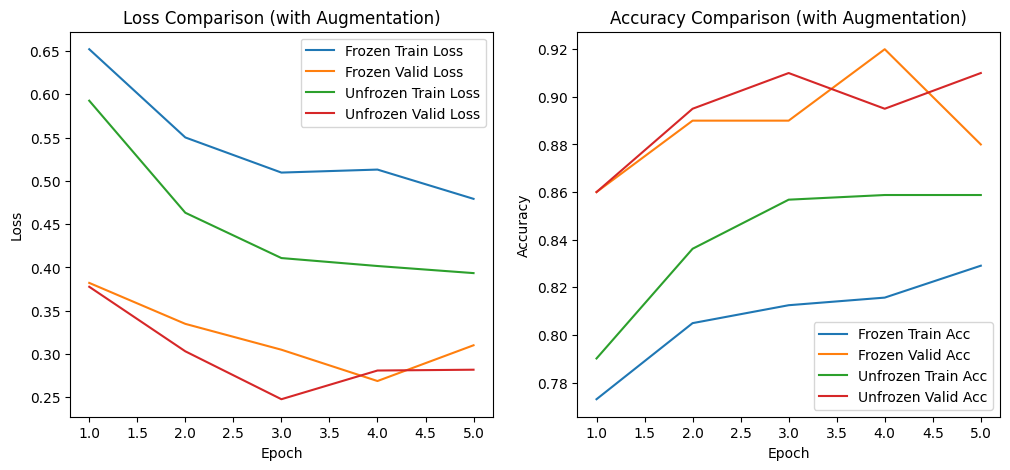

In [39]:
num_epochs = 5

history = {
    "frozen_train_loss": [],
    "frozen_valid_loss": [],
    "frozen_train_acc": [],
    "frozen_valid_acc": [],
    "unfrozen_train_loss": [],
    "unfrozen_valid_loss": [],
    "unfrozen_train_acc": [],
    "unfrozen_valid_acc": [],
}

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Frozen Backbone 학습 & 검증
    f_train_loss, f_train_acc = train_one_epoch(model_frozen, train_loader, optimizer_frozen, criterion, device)
    f_valid_loss, f_valid_acc = validate_one_epoch(model_frozen, valid_loader, criterion, device)

    # Unfrozen Backbone 학습 & 검증
    u_train_loss, u_train_acc = train_one_epoch(model_unfrozen, train_loader, optimizer_unfrozen, criterion, device)
    u_valid_loss, u_valid_acc = validate_one_epoch(model_unfrozen, valid_loader, criterion, device)

    # 기록
    history["frozen_train_loss"].append(f_train_loss)
    history["frozen_valid_loss"].append(f_valid_loss)
    history["frozen_train_acc"].append(f_train_acc)
    history["frozen_valid_acc"].append(f_valid_acc)

    history["unfrozen_train_loss"].append(u_train_loss)
    history["unfrozen_valid_loss"].append(u_valid_loss)
    history["unfrozen_train_acc"].append(u_train_acc)
    history["unfrozen_valid_acc"].append(u_valid_acc)

    print(f"[Frozen] Train Loss: {f_train_loss:.4f} | Valid Loss: {f_valid_loss:.4f} | Train Acc: {f_train_acc:.4f} | Valid Acc: {f_valid_acc:.4f}")
    print(f"[Unfrozen] Train Loss: {u_train_loss:.4f} | Valid Loss: {u_valid_loss:.4f} | Train Acc: {u_train_acc:.4f} | Valid Acc: {u_valid_acc:.4f}")

# ✅ 성능 그래프
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["frozen_train_loss"], label="Frozen Train Loss")
plt.plot(epochs, history["frozen_valid_loss"], label="Frozen Valid Loss")
plt.plot(epochs, history["unfrozen_train_loss"], label="Unfrozen Train Loss")
plt.plot(epochs, history["unfrozen_valid_loss"], label="Unfrozen Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Comparison (with Augmentation)")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["frozen_train_acc"], label="Frozen Train Acc")
plt.plot(epochs, history["frozen_valid_acc"], label="Frozen Valid Acc")
plt.plot(epochs, history["unfrozen_train_acc"], label="Unfrozen Train Acc")
plt.plot(epochs, history["unfrozen_valid_acc"], label="Unfrozen Valid Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison (with Augmentation)")
plt.legend()

plt.show()
